In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
parent_dir=""                    #to be changed if run on different computers
image_dir=parent_dir+"cropped/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import random
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,UpSampling2D,Reshape,LeakyReLU,Flatten,Input,Conv2DTranspose,Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm_notebook
from time import time
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import initializers

In [4]:
imgs=[]
for file in tqdm_notebook(os.listdir(image_dir)):
    
    img=cv2.imread(image_dir+file) 
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=img.astype("float",copy=False)   
    img=(img-127.5)/127.5
    img=cv2.resize(img,(32,32))
    imgs.append(img)
    
imgs=np.array(imgs)

C:\Users\akshay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [5]:
imgs.shape

(9798, 32, 32, 3)

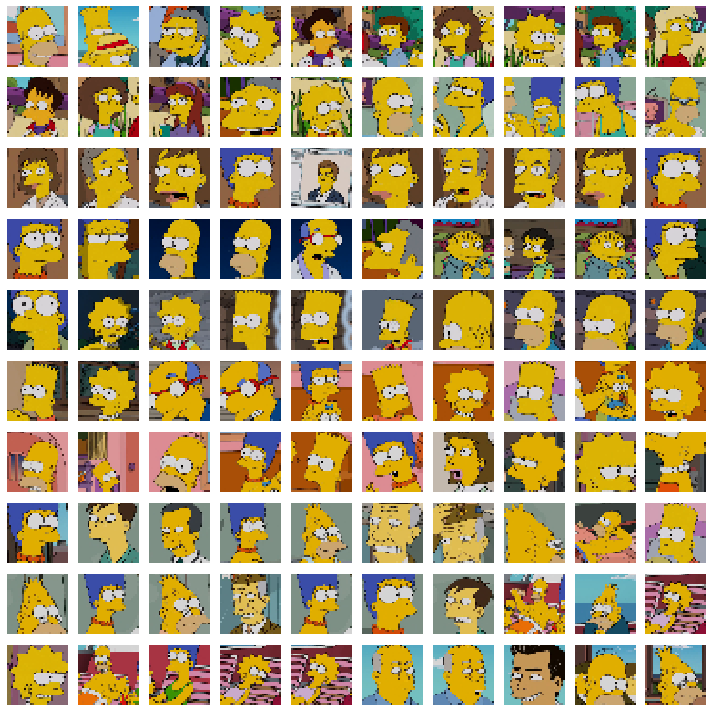

In [6]:
ax=plt.figure(figsize=(10,10))
for i in range(100): 

    img=imgs[i]
    img=((img+1)*127.5).astype(np.uint8)

    ax.add_subplot(10,10,i+1)
    plt.imshow(img)

    plt.axis("off")
    plt.tight_layout()
plt.show()

In [7]:
n_epochs=1000
batch_size=256
n_batches=int(imgs.shape[0]/batch_size)
noise_dim=100

#optd=Adam(lr=0.00004,beta_1=0.5)
opt=Adam(lr=0.0002,beta_1=0.5)

In [8]:
init=initializers.RandomNormal(mean=0.0,stddev=0.02)

gen=Sequential()                                   

gen.add(Dense(4*4*256,input_shape=(noise_dim,),kernel_initializer=init))
gen.add(LeakyReLU(0.2))
gen.add(Reshape((4,4,256)))
#gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
#shape of output: (4,4,256)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(64,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same")) 
gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
gen.add(LeakyReLU(0.2))
#shape of output: (8,8,128)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(32,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same")) 
gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
gen.add(LeakyReLU(0.2))
#shape of output: (16,16,128)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(16,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same")) 
gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
gen.add(LeakyReLU(0.2))
#shape of output: (32,32,128)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(8,(5,5),padding="same"))                             
# gen.add(Conv2DTranspose(64,(5,5),strides=(1,1),padding="same")) 
# gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
# gen.add(LeakyReLU(0.2))
#shape of output: (64,64,64)

# gen.add(UpSampling2D((2,2)))                                         
# gen.add(Conv2D(3,(5,5),padding="same",activation="tanh"))            
gen.add(Conv2DTranspose(3,(3,3),padding="same",strides=(1,1),activation="tanh"))
gen.add(BatchNormalization(epsilon=0.00005,momentum=0.8))
gen.add(LeakyReLU(0.2))
#shape of output: (32,32,3)

gen.add(Conv2D(3,(5,5),strides=(1,1),padding='same',activation='tanh'))

#gen.compile(optimizer=opt,loss="binary_crossentropy")
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       2

In [9]:
disc=Sequential()                 

disc.add(Conv2D(64,(3,3),strides=1,padding="same",input_shape=(32,32,3),kernel_initializer=init)) 
disc.add(BatchNormalization(epsilon=0.00005,momentum=0.8))      
disc.add(LeakyReLU(0.2))
#shape of output: (32,32,64)

disc.add(Conv2D(128,(5,5),strides=2,padding="same"))    
disc.add(BatchNormalization(epsilon=0.00005,momentum=0.8))                        
disc.add(LeakyReLU(0.2))
#shape of output: (16,16,128)

disc.add(Conv2D(128,(5,5),strides=2,padding="same"))  
disc.add(BatchNormalization(epsilon=0.00005,momentum=0.8))                      
disc.add(LeakyReLU(0.2))
#shape of output: (8,8,128)

# disc.add(Conv2D(512,(5,5),strides=1,padding="same"))   
# disc.add(BatchNormalization(epsilon=0.00005,momentum=0.8))                    
# disc.add(LeakyReLU(0.2))
# #shape of output: (16,16,512)

disc.add(Conv2D(256,(5,5),strides=2,padding="same"))  
disc.add(BatchNormalization(epsilon=0.00005,momentum=0.8))                         
disc.add(LeakyReLU(0.2))
#shape of output: (4,4,256)

disc.add(Flatten())
disc.add(Dropout(0.4))
disc.add(Dense(1,activation="sigmoid"))

disc.compile(loss="binary_crossentropy",optimizer=opt)
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)        

In [10]:
# disc.trainable=False

# gan_input=Input(shape=(noise_dim,))
# gen_img=gen(gan_input)
# gan_output=disc(gen_img)

# model=Model(gan_input,gan_output)
# model.compile(loss="binary_crossentropy",optimizer=opt)
# model.summary()
disc.trainable=False
model=Sequential()
model.add(gen)
model.add(disc)
model.compile(loss='binary_crossentropy',optimizer=opt)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         1467891   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1442305   
Total params: 2,910,196
Trainable params: 1,467,117
Non-trainable params: 1,443,079
_________________________________________________________________


In [11]:
def show_imgs(n_samples=100):                        #n_samples is the no. of images that u want to plot
    
    noise=np.random.randn(n_samples,noise_dim)
    gen_imgs=gen.predict(noise)
    gen_imgs=((gen_imgs+1)*127.5).astype(np.uint8)

    ax=plt.figure(figsize=(10,10))
    for i in range(n_samples):
        plt.subplot(10,10,i+1)
        plt.imshow(gen_imgs[i])

        plt.axis("off")
        plt.tight_layout()

    plt.show()

C:\Users\akshay\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


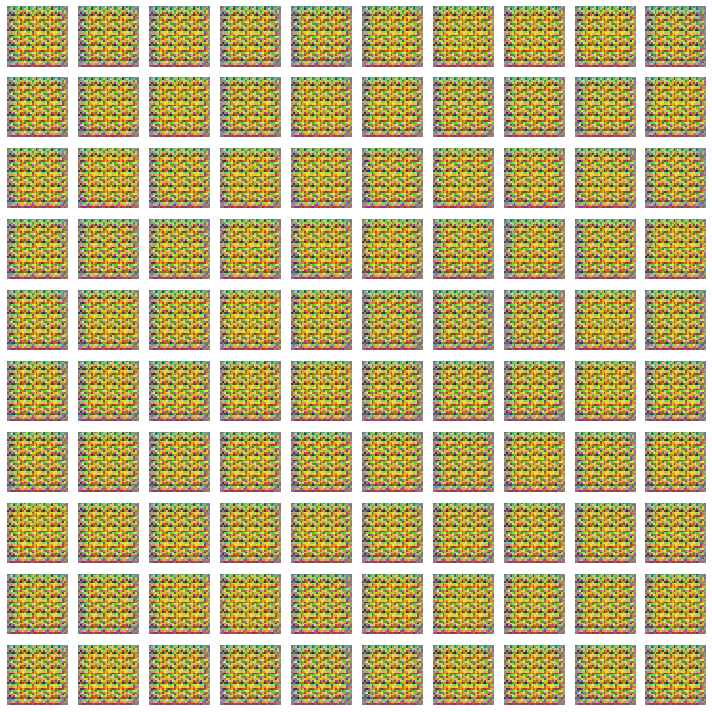

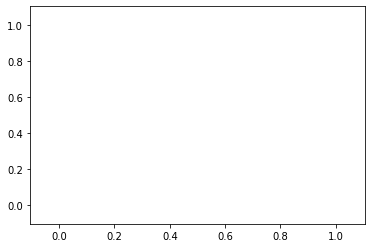

Epoch:  0  Average Discriminator Loss:  0.041389987512957305  Average Generator Loss:  0.8019491082523018
Epoch:  1  Average Discriminator Loss:  0.03224420821061358  Average Generator Loss:  0.9800952151417732
Epoch:  2  Average Discriminator Loss:  0.028774716600310057  Average Generator Loss:  0.7778196260333061
Epoch:  3  Average Discriminator Loss:  0.030649648746475577  Average Generator Loss:  0.9135786853730679
Epoch:  4  Average Discriminator Loss:  0.02975429274374619  Average Generator Loss:  0.8895360035821795


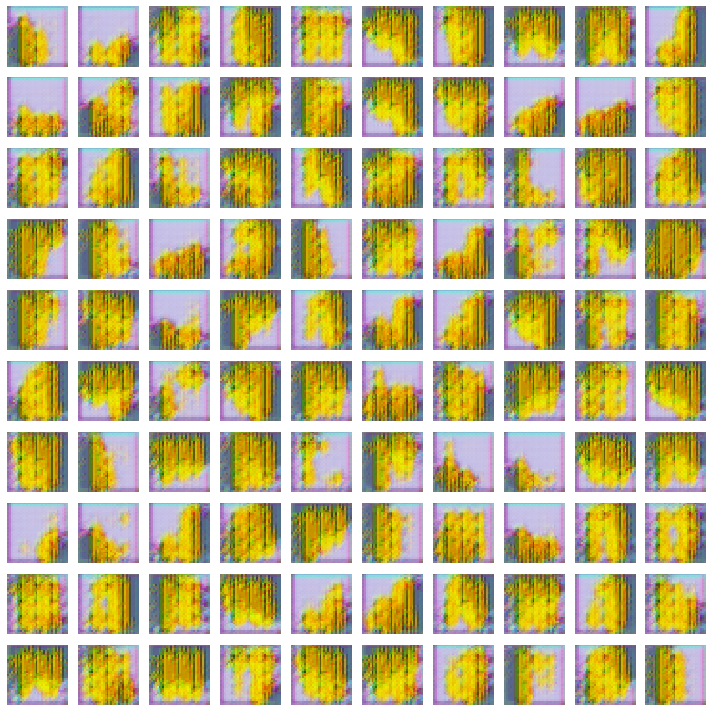

Epoch:  5  Average Discriminator Loss:  0.026790461386553943  Average Generator Loss:  0.9398758485913277
Epoch:  6  Average Discriminator Loss:  0.030844011693261564  Average Generator Loss:  0.8511456665582955
Epoch:  7  Average Discriminator Loss:  0.02694723504828289  Average Generator Loss:  1.2034257748164237
Epoch:  8  Average Discriminator Loss:  0.027080069645307958  Average Generator Loss:  0.9443622403778136
Epoch:  9  Average Discriminator Loss:  0.026497073762584478  Average Generator Loss:  1.0433095963671803


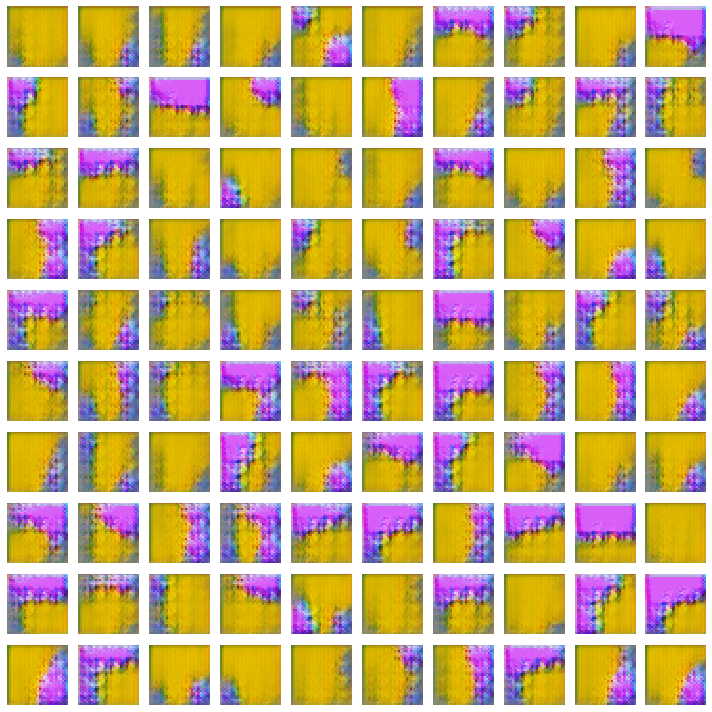

Epoch:  10  Average Discriminator Loss:  0.025873338454402983  Average Generator Loss:  1.057908701710403
Epoch:  11  Average Discriminator Loss:  0.02792255365056917  Average Generator Loss:  0.8525491915643215
Epoch:  12  Average Discriminator Loss:  0.02582648699171841  Average Generator Loss:  0.9846025919541717
Epoch:  13  Average Discriminator Loss:  0.025736952375154942  Average Generator Loss:  0.9536366802640259
Epoch:  14  Average Discriminator Loss:  0.025779477786272764  Average Generator Loss:  1.0801054104231298


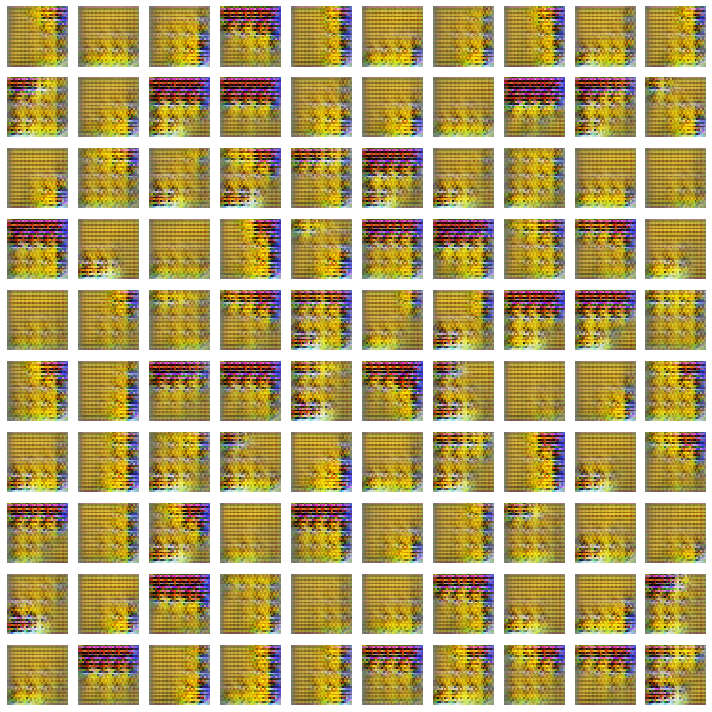

Epoch:  15  Average Discriminator Loss:  0.026214952813461423  Average Generator Loss:  0.8725330389570445
Epoch:  16  Average Discriminator Loss:  0.02539780124789104  Average Generator Loss:  1.1667372940573841
Epoch:  17  Average Discriminator Loss:  0.027979488717392087  Average Generator Loss:  1.3168523223139346
Epoch:  18  Average Discriminator Loss:  0.026804911612998694  Average Generator Loss:  0.41828656080178916
Epoch:  19  Average Discriminator Loss:  0.025556589069310576  Average Generator Loss:  1.214793256483972


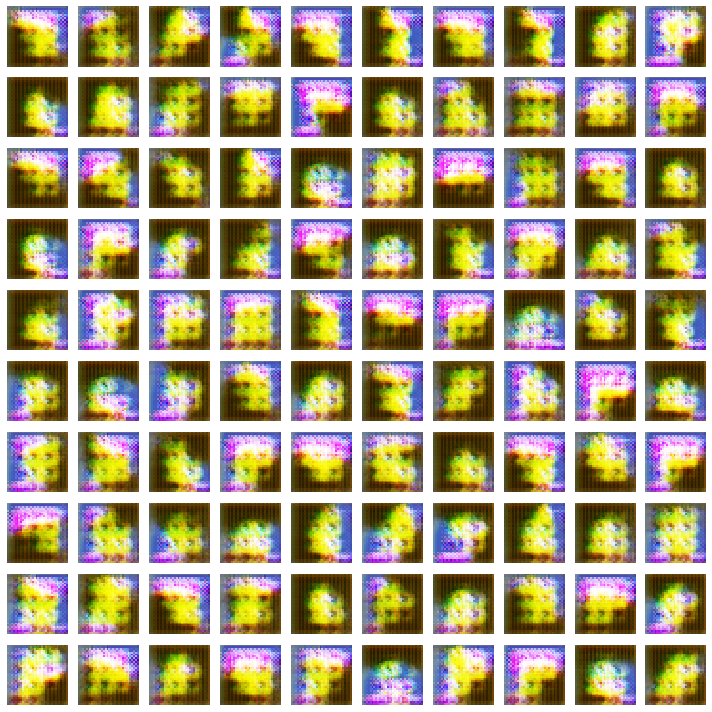

Epoch:  20  Average Discriminator Loss:  0.030200831941328943  Average Generator Loss:  0.8303699647076428
Epoch:  21  Average Discriminator Loss:  0.028164748393464833  Average Generator Loss:  1.2355990670621395


KeyboardInterrupt: 

In [12]:
gloss=[]
dloss=[]

for i in tqdm_notebook(range(300)):

    gen_loss=0
    disc_loss=0

    for batch in range(n_batches):

        #Training the Discriminator:
#         random_idx=np.random.randint(0,imgs.shape[0],size=int(batch_size/2))
#         real_imgs=imgs[random_idx]
        start=int(batch*(batch_size/2))
        end=int((batch*(batch_size/2))+(batch_size/2))

        real_imgs=imgs[start:end]
        real_labels=np.ones(int(batch_size/2))*0.9#*random.uniform(0.9,1.0)

        noise=np.random.randn(int(batch_size/2),noise_dim)
        fake_imgs=gen.predict(noise)
        fake_labels=np.zeros(int(batch_size/2))

        total_imgs=np.vstack((real_imgs,fake_imgs))
        total_labels=np.hstack((real_labels,fake_labels))

        disc_loss+=disc.train_on_batch(total_imgs,total_labels)

        #Training the Generator:
        noise=np.random.randn(batch_size,noise_dim)
        labels=np.ones(batch_size)

        gen_loss+=model.train_on_batch(noise,labels)

    if i%5==0:
        show_imgs()
        # e=np.arange(i)
        # plt.plot(e,gloss,c="g")
        # plt.plot(e,dloss,c="r")

        # plt.show()

        # gen.save(parent_dir+"cartoon.h5")

    if i%50==0:
        e=np.arange(i)
        plt.plot(e,gloss,c="g")
        plt.plot(e,dloss,c="r")

        plt.show()

    print("Epoch: ",i," Average Discriminator Loss: ",disc_loss/batch_size," Average Generator Loss: ",gen_loss/batch_size)

    gloss.append(gen_loss/batch_size)
    dloss.append(disc_loss/batch_size)

    # if i>0 and gloss[-2]>gloss[-1]:
    #     gen.save(parent_dir+"cartoon.h5")